# 목적 : 인물 모드 문제점 찾기

In [1]:
from importlib.metadata import version
import cv2
import os
import urllib
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


인물 사진

(926, 750, 3)


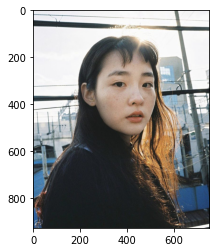

In [2]:
# 준비한 이미지 읽기
img_path_1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/김민하.png'  
img_orig_1 = cv2.imread(img_path_1) 

print(img_orig_1.shape)
plt.imshow(cv2.cvtColor(img_orig_1, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# PixelLib에서 제공해 주는 모델을 다운로드
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f967351d550>)

In [4]:
# 다운로드한 모델을 이용해 PixelLib로 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path_1)

In [6]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

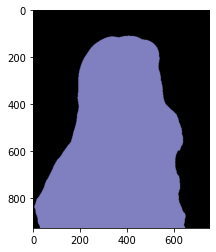

In [7]:
# 모델에서 나온 출력값
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
# 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내기
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
# 사람을 나타내는 15번째 색상
colormap[15]

array([192, 128, 128])

In [12]:
# output 이미지가 BGR 순서로 채널 배치 RGB로 바꿔주기
seg_color = (128,128,192)

(926, 750)


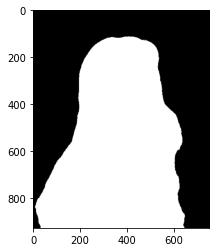

In [13]:
# seg_color로만 이루어진 마스크를 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

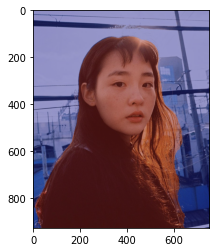

In [14]:
# 원래 이미지와 겹쳐 보기
img_show_1 = img_orig_1.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_1 = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask_1 = cv2.applyColorMap(img_mask_1, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show_1 = cv2.addWeighted(img_show_1, 0.6, color_mask_1, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_1, cv2.COLOR_BGR2RGB))
plt.show()

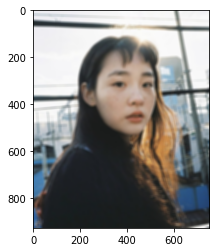

In [15]:
# blur() 함수를 이용, 배경 흐리게
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur_1 = cv2.blur(img_orig_1, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur_1, cv2.COLOR_BGR2RGB))
plt.show()

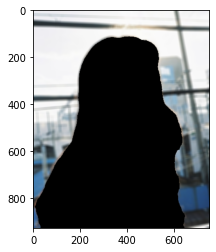

In [16]:
# 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color_1 = cv2.cvtColor(img_mask_1, cv2.COLOR_GRAY2BGR)
img_bg_mask_1 = cv2.bitwise_not(img_mask_color_1)
img_bg_blur_1 = cv2.bitwise_and(img_orig_blur_1, img_bg_mask_1)
plt.imshow(cv2.cvtColor(img_bg_blur_1, cv2.COLOR_BGR2RGB))
plt.show()

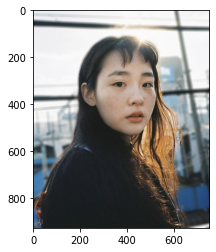

In [17]:
# 배경 영상과 사람 영상을 합치기
img_concat_1 = np.where(img_mask_color_1==255, img_orig_1, img_bg_blur_1)
plt.imshow(cv2.cvtColor(img_concat_1, cv2.COLOR_BGR2RGB))
plt.show()

고양이 사진

(194, 259, 3)


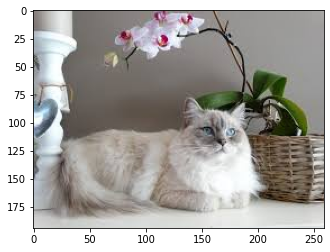

In [18]:
# 준비한 이미지 읽기
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.png'  
img_orig_2 = cv2.imread(img_path_2) 

print(img_orig_2.shape)
plt.imshow(cv2.cvtColor(img_orig_2, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path_2)

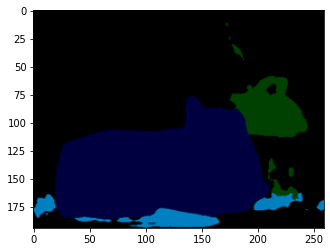

In [20]:
# 모델에서 나온 출력값
plt.imshow(output)
plt.show()

In [21]:
segvalues

{'class_ids': array([ 0,  8, 11, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [22]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
diningtable
pottedplant


In [23]:
# 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내기
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [24]:
# 사람을 나타내는 15번째 색상
colormap[8]

array([64,  0,  0])

In [25]:
# output 이미지가 BGR 순서로 채널 배치 RGB로 바꿔주기
seg_color = (0, 0, 64)

(194, 259)


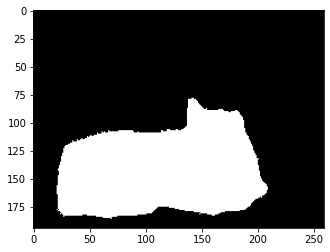

In [26]:
# seg_color로만 이루어진 마스크를 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

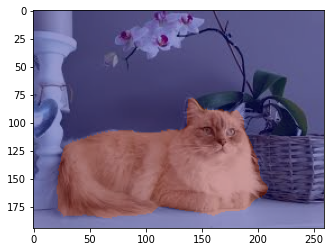

In [27]:
# 원래 이미지와 겹쳐 보기
img_show_2 = img_orig_2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_2 = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask_2 = cv2.applyColorMap(img_mask_2, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show_2 = cv2.addWeighted(img_show_2, 0.6, color_mask_2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB))
plt.show()

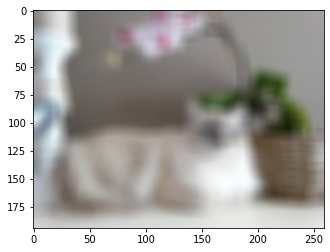

In [28]:
# blur() 함수를 이용, 배경 흐리게
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur_2 = cv2.blur(img_orig_2, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur_2, cv2.COLOR_BGR2RGB))
plt.show()

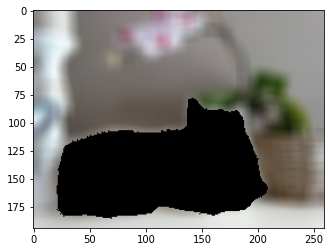

In [29]:
# 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color_2 = cv2.cvtColor(img_mask_2, cv2.COLOR_GRAY2BGR)
img_bg_mask_2 = cv2.bitwise_not(img_mask_color_2)
img_bg_blur_2 = cv2.bitwise_and(img_orig_blur_2, img_bg_mask_2)
plt.imshow(cv2.cvtColor(img_bg_blur_2, cv2.COLOR_BGR2RGB))
plt.show()

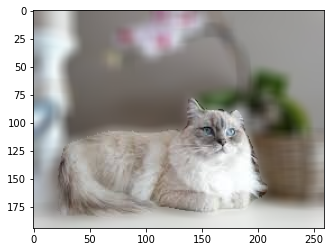

In [30]:
# 배경 영상과 사람 영상을 합치기
img_concat_2 = np.where(img_mask_color_2==255, img_orig_2, img_bg_blur_2)
plt.imshow(cv2.cvtColor(img_concat_2, cv2.COLOR_BGR2RGB))
plt.show()

크로마키

(184, 274, 3)


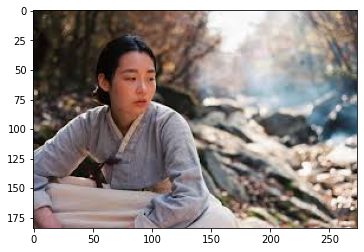

In [31]:
# 준비한 이미지 읽기
img_path_3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/김민하3.png'  
img_orig_3 = cv2.imread(img_path_3) 

print(img_orig_3.shape)
plt.imshow(cv2.cvtColor(img_orig_3, cv2.COLOR_BGR2RGB))
plt.show()

In [32]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path_3)

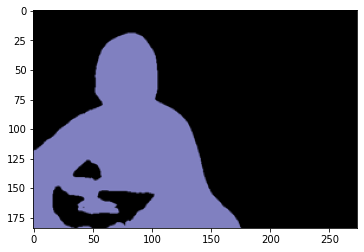

In [33]:
# 모델에서 나온 출력값
plt.imshow(output)
plt.show()

In [34]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [35]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [36]:
# 사람을 나타내는 15번째 색상
colormap[15]

array([192, 128, 128])

In [37]:
# output 이미지가 BGR 순서로 채널 배치 RGB로 바꿔주기
seg_color = (128, 128, 192)

(184, 274)


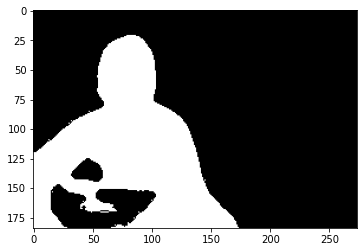

In [38]:
# seg_color로만 이루어진 마스크를 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

(184, 274, 3)


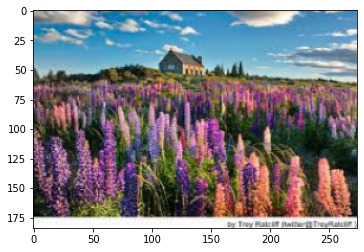

In [39]:
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/배경.png'  
bg_orig = cv2.imread(bg_path) 
bg_orig = cv2.resize(bg_orig, dsize=(274,184))

print(bg_orig.shape)
plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
plt.show()

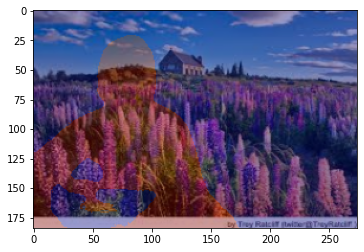

In [40]:
# 원래 이미지와 겹쳐 보기
img_show = bg_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

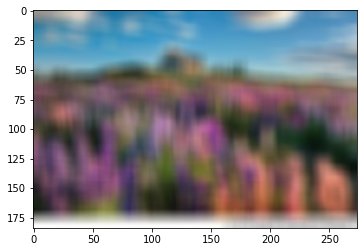

In [41]:
# blur() 함수를 이용, 배경 흐리게
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
bg_orig_blur = cv2.blur(bg_orig, (13,13))  
plt.imshow(cv2.cvtColor(bg_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

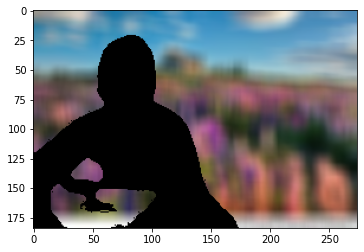

In [42]:
# 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
bg_mask = cv2.bitwise_not(img_mask_color)
bg_blur = cv2.bitwise_and(bg_orig_blur, bg_mask)
plt.imshow(cv2.cvtColor(bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

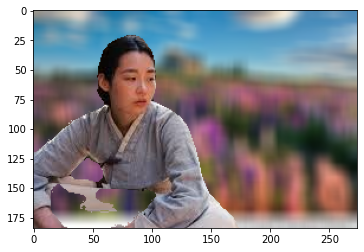

In [43]:
# 배경 영상과 사람 영상을 합치기
img_concat = np.where(img_mask_color==255, img_orig_3, bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 해결 방법을 제안

일단 인물모드를 사용했을 때의 문제점은
1. 피사체와 배경의 경계가 애매함.
2. 크로마키를 했을 때의 문제점은 정확하게 알 수 없으나 아마 피사체의 자세로 인해 발생한 거리?차이 때문에 발생한 듯함.

이 문제점들은 우리가 사용한 DeepLab 모델의 Semantic Segmentation의 문제점으로 보임.

## 해결방안
### - uDepth: Pixel 4의 실시간 3D 깊이 감지

    - uDepth는 각 픽셀에 대해 계산 시차를 추정하는 조밀한 로컬 스테레오 매칭 기술 제품군의 일부입니다. 이러한 기술은 하나의 카메라로 형성된 이미지에서 각 픽셀을 둘러싼 영역을 평가하고 두 번째 카메라에서 해당 이미지에서 유사한 영역을 찾으려고 합니다. 적절하게 보정된 경우 생성된 재구성은 미터법 으로 실제 물리적 거리를 나타냅니다.
    
    - 이처럼 물리적 거리나 깊이를 측정하여 영역을 평가하기 때문에 1,2번의 문제점을 모두 해결 할 것으로 보임.
    
    
### - 차세대 3D 이미지센서 소자 - 단광자눈사태다이오드(SPAD)

    - 최근 차세대 이미지센서 시장을 주도할 새로운 폼팩터(Form Factor)로는 ‘3D 이미지센서’가 크게 각광받고 있다. 기존 이미지센서는 2D 이미지만 구현할 수 있는 데 반해, 3D 이미지센서는 사물까지의 거리(심도)를 측정함으로써 더 정밀하게 물체나 동작을 인식해 이를 3D 이미지로 구현할 수 있기 때문이다. 
    
    - 3D 이미지센서가 3D 이미지를 얻는 방식은 크게 양안 시각(Stereo Vision)4) 방식, 구조 광(Structured Light)5) 방식, 비행시간(Time of Flight, 이하 ToF) 방식으로 분류된다. 이중 ToF 방식은 거리 측정 방식에 따라 위상 차이를 이용하는 ‘간접 ToF(Indirect ToF, 이하 I-ToF)’와 시간 차이를 직접 측정하는 방식인 ‘직접 ToF(Direct ToF, 이하 D-ToF)’로 구분된다. 
    
    - SPAD 소자는 광자가 소자로 들어왔을 때 출력으로 디지털 펄스(Digital Pulse)를 내보내는 특성이 있기 때문에, 이를 이용한 비행시간 측정이 용이하다. 이뿐만 아니라, 아주 미세한 시간차를 잡아낼 수 있는 특성도 갖고 있어 ㎜~㎝ 범위에서도 ‘심도 분해능(Depth Resolution)’11)을 얻을 수가 있다.
    
    - 심도 분해능(Depth Resolution): 아주 밀접한 차이로 서로 떨어져 있는 두 물체를 구별할 수 있는 능력.
    
    - 특히 심도 분해능이라는 것을 얻음으로써 피사체와 배경의 경계를 더욱 정확하게 나눌 수 있을 것이다.